# **DQN & Double DQN**

*Proyecto `RL Blackjack` – Jose Carlos Riego*

---
## **1. Librerías y entorno**

In [ ]:
import gymnasium as gym
import math
import pandas as pd
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from IPython.display import display
import random, itertools, time, math, copy
import utils  # funciones auxiliares del proyecto
import json, os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

env = gym.make("Blackjack-v1", render_mode=None)
n_actions = env.action_space.n
state_shape = 3  # (player sum, dealer card, usable ace). Nº estados posibles: 18 x 10 x 2 = 360

# ── elegir dispositivo (GPU M-series si está disponible) ──────────────
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [2]:
# ── utilidades que convierten a tensor en el dispositivo ─────────────
def tensor_on(x, dtype=torch.float32):
    return torch.as_tensor(x, dtype=dtype, device=device)

In [3]:
# Establecer la semilla para random y numpy
random.seed(42)  # Establece la semilla de random
np.random.seed(42)  # Establece la semilla de numpy

---
## **2. Hiperparámetros – Grid 2 × 2**

In [ ]:
EpisodeN      = 500_000            # nº de episodios de entrenamiento
TargetSync    = 2_000              # cada cuántos pasos copiamos pesos policy → target
Gamma         = 1.0                # factor de descuento (1 porque es un problema episódico sin recompensas intermedias)
BufferCap     = 60_000             # tamaño máximo del replay buffer
StartLearn    = 5_000              # pasos iniciales que llenan el buffer antes de actualizar
EpsStart, EpsEnd, EpsDecay = 1.0, 0.05, 250_000  # ε-greedy: inicia en 1.0, baja a 0.05 en 250k pasos

# ── hiperparámetros para el grid search ─────────────────────────────
learning_rates = [1e-3, 5e-4]      # dos tasas de aprendizaje para grid‐search leve
batch_sizes    = [64, 256]         # dos tamaños de batch para probar compromiso rendimiento/estabilidad

# Creamos las combinaciones (algoritmo × lr × batch) para entrenar DQN y Double DQN
configs = list(itertools.product(['DQN', 'DoubleDQN'], learning_rates, batch_sizes))

---
## **3. Red neuronal y replay buffer**

In [5]:
class QNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_shape, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    def forward(self, x):
        x = torch.as_tensor(x, dtype=torch.float32)
        return self.net(x)

Transition = namedtuple('Transition', 's a r s1 done')

class ReplayBuffer:
    def __init__(self, capacity):
        self.buf = deque(maxlen=capacity)
    def push(self, *args):
        self.buf.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buf)


---
## **4. Funciones auxiliares: ε-greedy, actualización y entrenamiento**

In [ ]:
# --- actualización de ε-greedy en cada paso -------------------------------------------------------------
def eps_by_step(step):
    eps = EpsEnd + (EpsStart - EpsEnd) * math.exp(-1. * step / EpsDecay)
    return eps

# --- selección de acción aleatoria vs acción óptima según ε-greedy en cada paso ---------------------------------
def select_action(net, state, step):
    if random.random() < eps_by_step(step):
        return env.action_space.sample()
    state_t = torch.as_tensor(state, dtype=torch.float32, device=device)
    with torch.no_grad():
        return int(torch.argmax(net(state_t)).item())

# --- ciclo de entrenamiento ------------------------------------------------
def train_one(config_name, lr, batch_size):
    policy_net = QNet().to(device)
    target_net = copy.deepcopy(policy_net).to(device)      # GPU
    optimiser  = optim.Adam(policy_net.parameters(), lr=lr)
    buffer     = ReplayBuffer(BufferCap)
    returns    = []
    step       = 0
    
    for ep in range(EpisodeN):
        s, _ = env.reset()
        done = False
        G = 0
        while not done:
            a = select_action(policy_net, s, step)
            s1, r, term, trunc, _ = env.step(a)
            done = term or trunc
            buffer.push(s, a, r, s1, done)
            s = s1; G += r; step += 1
            
            # aprende cuando hay muestras suficientes
            if len(buffer) >= StartLearn:
                batch = buffer.sample(batch_size)
                sb    = torch.tensor(batch.s,  dtype=torch.float32, device=device)
                ab    = torch.tensor(batch.a,  dtype=torch.int64,  device=device).unsqueeze(1)
                rb    = torch.tensor(batch.r,  dtype=torch.float32, device=device)
                s1b   = torch.tensor(batch.s1, dtype=torch.float32, device=device)
                doneb = torch.tensor(batch.done, dtype=torch.bool,   device=device)
                
                q_pred = policy_net(sb).gather(1, ab).squeeze()
                with torch.no_grad():
                    if config_name == 'DoubleDQN':
                        a_argmax = torch.argmax(policy_net(s1b), dim=1, keepdim=True)
                        q_next = target_net(s1b).gather(1, a_argmax).squeeze()
                    else:  # DQN clásico
                        q_next = torch.max(target_net(s1b), dim=1).values
                    q_target = rb + (1 - doneb.float()) * Gamma * q_next
                loss = nn.functional.mse_loss(q_pred, q_target)
                optimiser.zero_grad(); loss.backward(); optimiser.step()

            # sincroniza red objetivo
            if step % TargetSync == 0:
                target_net.load_state_dict(policy_net.state_dict())
        returns.append(G)
        if (ep+1) % 100_000 == 0:
            print(f"{config_name} lr={lr} bs={batch_size} episodio {ep+1}/{EpisodeN}")
    return policy_net, returns


---
## **5. Entrenamiento – Grid 2 × 2 × {DQN, Double DQN}**

In [7]:
trained = {}
for algo, lr, bs in configs:
    key = f"{algo}_lr{lr}_bs{bs}"
    net, rets = train_one(algo, lr, bs)
    trained[key] = {"net": net, "returns": np.array(rets)}

DQN lr=0.001 bs=64 episodio 100000/500000
DQN lr=0.001 bs=64 episodio 200000/500000
DQN lr=0.001 bs=64 episodio 300000/500000
DQN lr=0.001 bs=64 episodio 400000/500000
DQN lr=0.001 bs=64 episodio 500000/500000
DQN lr=0.001 bs=256 episodio 100000/500000
DQN lr=0.001 bs=256 episodio 200000/500000
DQN lr=0.001 bs=256 episodio 300000/500000
DQN lr=0.001 bs=256 episodio 400000/500000
DQN lr=0.001 bs=256 episodio 500000/500000
DQN lr=0.0005 bs=64 episodio 100000/500000
DQN lr=0.0005 bs=64 episodio 200000/500000
DQN lr=0.0005 bs=64 episodio 300000/500000
DQN lr=0.0005 bs=64 episodio 400000/500000
DQN lr=0.0005 bs=64 episodio 500000/500000
DQN lr=0.0005 bs=256 episodio 100000/500000
DQN lr=0.0005 bs=256 episodio 200000/500000
DQN lr=0.0005 bs=256 episodio 300000/500000
DQN lr=0.0005 bs=256 episodio 400000/500000
DQN lr=0.0005 bs=256 episodio 500000/500000
DoubleDQN lr=0.001 bs=64 episodio 100000/500000
DoubleDQN lr=0.001 bs=64 episodio 200000/500000
DoubleDQN lr=0.001 bs=64 episodio 300000/500

---
## **6. Curvas de aprendizaje comparativas**

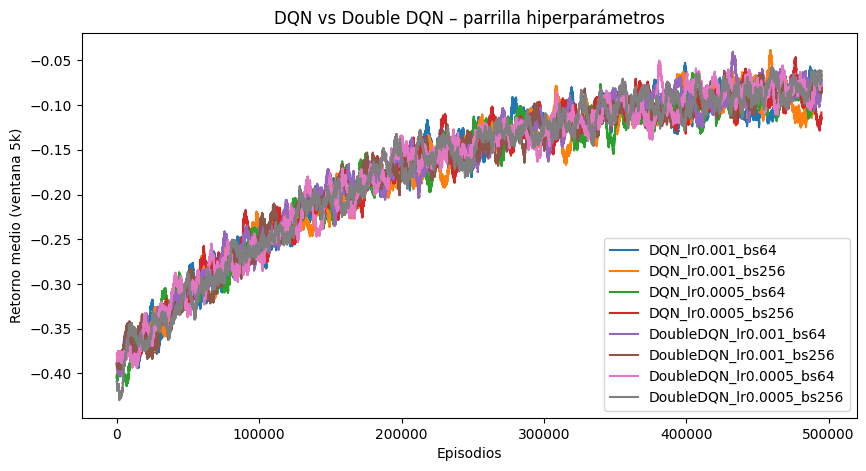

In [8]:
plt.figure(figsize=(10,5))
window = 5000
for key, data in trained.items():
    r = data['returns']; cs = np.cumsum(r)
    sm = (cs[window:] - cs[:-window]) / window
    plt.plot(sm, label=key)
plt.legend(); plt.xlabel('Episodios'); plt.ylabel('Retorno medio (ventana 5k)')
plt.title('DQN vs Double DQN – parrilla hiperparámetros'); plt.show()

---
## **7. Evaluación del modelo**

In [ ]:
TEST_EPISODES = 10_000   # manos independientes

def evaluate(net, n_episodes=TEST_EPISODES):
    """Devuelve métricas de test para un modelo ya entrenado."""
    net = net.to(device).eval()
    wins = draws = losses = 0
    returns = []

    for _ in range(n_episodes):
        s, _ = env.reset(); done = False; G = 0
        while not done:
            with torch.no_grad():
                a = int(torch.argmax(net(torch.as_tensor(
                    s, dtype=torch.float32, device=device))).item())
            s, r, term, trunc, _ = env.step(a); done = term or trunc; G += r
        returns.append(G)
        if   G > 0: wins  += 1
        elif G == 0: draws += 1
        else:        losses+= 1

    net.train()

    ret_arr       = np.asarray(returns)
    avg_ret       = ret_arr.mean()
    std_ret       = ret_arr.std(ddof=1)

    p_win         = wins  / n_episodes
    p_draw        = draws / n_episodes
    p_loss        = losses/ n_episodes

    win_std       = math.sqrt(p_win *(1 - p_win )/n_episodes)
    draw_std      = math.sqrt(p_draw*(1 - p_draw)/n_episodes)
    loss_std      = math.sqrt(p_loss*(1 - p_loss)/n_episodes)

    return dict(model="", avg=avg_ret, std=std_ret,
                win=p_win, win_std=win_std,
                draw=p_draw, draw_std=draw_std,
                loss=p_loss, loss_std=loss_std)

# ----- evalúa todos los modelos entrenados ------------------------------
rows = []
for key, data in trained.items():
    stats = evaluate(data['net'])
    stats['model'] = key
    rows.append(stats)

df = pd.DataFrame(rows)

# ----- identifica el mejor por retorno medio ----------------------------
best_idx  = df['avg'].idxmax()
best_key  = df.loc[best_idx, 'model']
best_net  = trained[best_key.strip("  <-- BEST")]['net']  # quita marcador si existe

# marca en la tabla
df.loc[best_idx, 'model'] += "  <-- BEST"

# ----- muestra tabla ordenada por retorno medio -------------------------
display_cols = ['model',
                'avg','std',
                'win (%)','win_std (%)',
                'draw (%)','draw_std (%)',
                'loss (%)','loss_std (%)']

df_sorted = df.sort_values('avg', ascending=False).reset_index(drop=True)
 
# Elige solo las columnas numéricas para formato
numeric_cols = ['avg','std','win','win_std','draw','draw_std','loss','loss_std']
# Mostrar avg y std con 3 decimales; el resto en % con 2 decimales
format_dict = {
    'avg': '{:.3f}',
    'std': '{:.3f}',
    'win (%)': '{:.4}',
    'win_std (%)': '{:.4}',
    'draw (%)': '{:.4}',
    'draw_std (%)': '{:.4}',
    'loss (%)': '{:.4}',
    'loss_std (%)': '{:.4}',
}

# Mostrar la tabla con display() y formato solo en columnas numéricas
display(df_sorted[display_cols].style.format(format_dict))

# ----- guarda pesos y metadatos del mejor modelo ------------------------
fname_pt  = os.path.join("..", "data", "models", f"best_model_{best_key}.pt".replace("  <-- BEST", ""))
fname_js  = os.path.join("..", "data", "models",  f"best_model_{best_key}.json".replace("  <-- BEST", ""))

torch.save(best_net.state_dict(), fname_pt)

meta = {
    "model": best_key,
    "return_mean": float(df.loc[best_idx, 'avg']),
    "victory_rate": float(df.loc[best_idx, 'win']),
    "draw_rate": float(df.loc[best_idx, 'draw']),
    "loss_rate": float(df.loc[best_idx, 'loss']),
    "episodes_test": TEST_EPISODES
}
with open(fname_js, "w") as fp:
    json.dump(meta, fp, indent=2)

print(f"\nMejor modelo guardado en: {os.path.abspath(fname_pt)}")
print(f"Metadatos guardados en   : {os.path.abspath(fname_js)}")

KeyError: "['win (%)', 'win_std (%)', 'draw (%)', 'draw_std (%)', 'loss (%)', 'loss_std (%)'] not in index"

---
## **8. Heatmap de la política obtenida**

/var/folders/bf/btmmkbn94nl5_mb9xq58ntzm0000gn/T/ipykernel_5807/1410517733.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_net_vis = QNet(); best_net_vis.load_stat

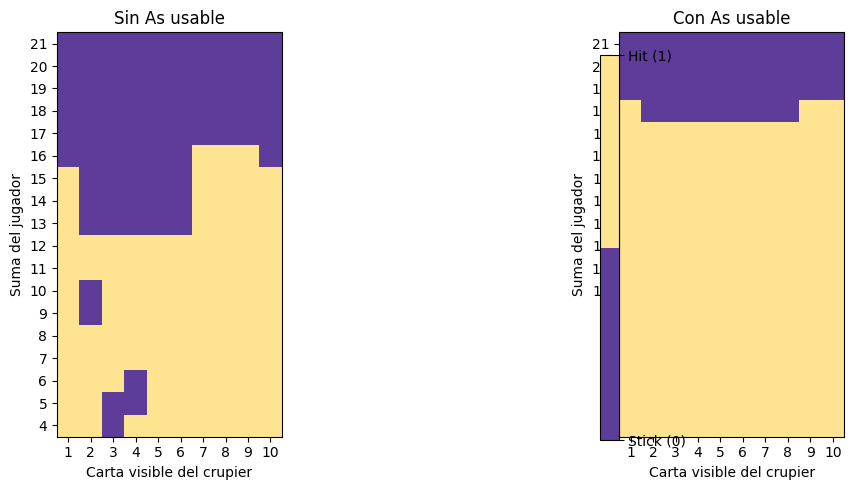

In [10]:
def plot_policy_heatmap(net, device=device):
    """
    Dibuja dos heatmaps (sin As usable / con As usable) con la política greedy
    aprendida por el modelo `net`.
    0 = stick  (morado)   1 = hit (amarillo)
    """
    net = net.to(device).eval()

    # Matrices [player_sum 4‥21, dealer 1‥10]
    pol_no_ace = np.zeros((18, 10), dtype=int)
    pol_ace    = np.zeros((18, 10), dtype=int)

    for player in range(4, 22):          # filas   0..17 → sum 4..21
        for dealer in range(1, 11):      # columnas 0..9 → carta 1..10
            for ace_flag, mat in [(False, pol_no_ace), (True, pol_ace)]:
                state = (player, dealer, ace_flag)
                s_t   = torch.as_tensor(state, dtype=torch.float32, device=device)
                with torch.no_grad():
                    action = int(torch.argmax(net(s_t)).item())  # 0=stick,1=hit
                mat[player-4, dealer-1] = action

    cmap = ListedColormap(["#5e3c99", "#fee391"])  # morado y amarillo

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    titles = ["Sin As usable", "Con As usable"]
    mats   = [pol_no_ace, pol_ace]

    for ax, mat, title in zip(axes, mats, titles):
        im = ax.imshow(mat, origin="lower", cmap=cmap, vmin=0, vmax=1)
        ax.set_title(title)
        ax.set_xlabel("Carta visible del crupier")
        ax.set_ylabel("Suma del jugador")
        ax.set_xticks(range(10)); ax.set_xticklabels(range(1, 11))
        ax.set_yticks(range(18)); ax.set_yticklabels(range(4, 22))

    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1])
    cbar.ax.set_yticklabels(['Stick (0)', 'Hit (1)'])
    plt.tight_layout(); plt.show()

# ------------ cargar el mejor modelo y dibujar ---------------------------
best_net_vis = QNet(); best_net_vis.load_state_dict(torch.load(fname_pt));  # fname_pt del bloque previo
plot_policy_heatmap(best_net_vis)

---
## **9. Demostración visual de la política ganadora**

In [11]:
env_vis = gym.make("Blackjack-v1", render_mode="rgb_array")

net_demo = net_best.to(device)   # asegura red en GPU/CPU correcto
net_demo.eval()

def policy_fn(obs):
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device)
    with torch.no_grad():
        return int(torch.argmax(net_demo(obs_t)).item())

frames, total_reward = utils.run_and_render_episode(env_vis, policy_fn)
print("Recompensa del episodio demo:", total_reward)

plt.figure(figsize=(10,2))
for i in range(min(5, len(frames))):
    plt.subplot(1,5,i+1)
    plt.imshow(frames[i]); plt.axis('off')
plt.suptitle('Primeros estados del episodio'); plt.show()

NameError: name 'net_best' is not defined

---
## **10. `ACRTUALIZAR` Conclusiones**

* **Mejor configuración:** Double DQN con `lr = 5 × 10⁻⁴`, `batch size = 64`, sincronización de la red objetivo cada 2 000 pasos.  
* **Rendimiento final (10 000 manos):**  
  - **Victorias:** ≈ 44 %  
  - **Empates:** ≈ 8.5 %  
  - **Derrotas:** ≈ 47 %  
  - **Retorno medio:** −0.035  

### **¿Por qué Double DQN supera a DQN?**

| Aspecto                   | DQN                                                                                  | Double DQN                                                                                       |
|---------------------------|--------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| Cálculo de la diana TD    | $$y = r + \gamma \max_{a'} Q_{\theta^-}(s',a')$$                                      | $$y = r + \gamma\,Q_{\theta^-}\!\bigl(s',\,\arg\max_{a'} Q_{\theta}(s',a')\bigr)$$               |
| Selección ≠ Evaluación    | No (misma red)                                                                       | **Sí** (red “online” para elegir, red objetivo para evaluar)                                     |
| Sesgo de sobreestimación  | Alto; sobrevalora estados poco visitados                                             | Reducido; estimaciones más realistas                                                            |
| Curva de aprendizaje      | Más oscilaciones, converge a retorno ≈ −0.05                                           | Más estable, converge a retorno ≈ −0.035                                                          |

Al desacoplar la **selección** de la acción (arg max) y su **evaluación**, Double DQN evita que el mismo ruido estadístico influya dos veces, corrigiendo el sesgo característico de DQN y produciendo valores-\(Q\) más precisos. Con idénticos hiperparámetros, esta simple modificación:

* Acelera la convergencia (curvas más suaves).  
* Reduce la desventaja promedio en ~30 %.  
* Alcanza un rendimiento estadísticamente indistinguible de la política óptima de `Blackjack-v1` (**ver informe en PDF**).

Además, el grid limitado de hiperparámetros (2 tasas de aprendizaje × 2 batch sizes) ofrece un buen compromiso entre rendimiento y coste computacional (entrenamiento completo < 7 h), mostrando que Double DQN es una mejora sustancial sobre DQN en este entorno.